# Investigating pricing factors inside the Real Estate market of Brazil
Created by: Anish Puthuraya, Anmol Srivastava, Hector He, Prateek Naharia, Yuesen Zhang
<hr>

## Table of Contents

#### I. [Introduction](#Introduction) 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a. Motivation

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b. Objective

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c. Report Summary

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d. Data Brief

#### II. [Data Reading](#DataReading) 



&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a. Input Data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b. Data Schema

#### III. [Data Cleaning](#DataCleaning)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a. Column Selection

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b. Spurious, Splits and Merges

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c. Imputing Nulls

#### IV. [Data Exploration](#DataExploration)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a. Basic Statistics

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b. Questions with Answers

#### V. [Conclusions](#Conclusions)

#### VI. [References](#References)

<hr>
<a id="Introduction"></a>


## I. Introduction
***

#### a. Motivation
A house is usually the most important purchase of an individual’s lifetime. With soaring prices and unpredictable factors such as socio-economic conditions as well as fraudulent listings, it is quite important to keep an objective eye in understanding the pricing landscape, which is what our analysis aims to achieve.

#### b. Objective
Our goal is to analyze the Monthly property listing data for Brazil with a focus on understanding the factors behind pricing of the listings, namely:

1. __Geographical__ - We will find optimal geographical locations in terms of price and quality of the location (with regards to Human Development Index) 

2. __Number/Area of rooms__ - Based on the number of rooms, we will find the relationship with the pricing of the properties. 

3. __Property Type__ - We will analyze the variation of price with property type (Houses, Apartments, Penthouses and Stores)

#### d. Data Brief 

The dataset contains the sale and rent listing of properties such as houses, apartments, stores, and penthouses available on Properati for Brazil as of January 2015.

The original dataset comprises __27__ fields (all nullable) and __169,220__ records and occupies 129.26 MB of storage as of November 15, 2022.

__Main Data sourced from
Brazil Real Estate Listings - BigQuery Public Datasets. See __[here](http://www.properati.com.br/dados)__.__

__Cities Data sourced from
https://www.kaggle.com/datasets/crisparada/brazilian-cities?select=BRAZIL_CITIES_REV2022.CSV__

__State Data sourced from
https://en.wikipedia.org/wiki/ISO_3166-2:BR__

<hr>
<a id="DataReading"></a>

## II. Data Reading
### a. Input Data
#### Import Packages

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
import seaborn as sns
!pip3 install lxml
import lxml

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

#### Get Real Estate Data

In [91]:
client = bigquery.Client()
sql = """
    SELECT * FROM `properati-data-public.properties_br.properties_rent_201501` UNION ALL
    SELECT * FROM `properati-data-public.properties_br.properties_sell_201501`
"""
main_data = client.query(sql).to_dataframe()

#### Get Cities Data

In [92]:
cities_data = pd.read_csv("gs://ba780-b1-supplementary-data/BRAZIL_CITIES_REV2022.CSV")

#### Get State Data

In [93]:
state_data = pd.read_html("https://en.wikipedia.org/wiki/ISO_3166-2:BR")[0]

<hr>

### b. Data Schema

#### Main Data
`id` - STRING - ID for the data.

`created_on` - OBJECT - The date the data are created.

`operation` - OBJECT - Operation of either rent or sell 

`property_type` - OBJECT - The type of the property includes store, apartment, and house.

`place_name` - OBJECT - The place name in Brazil.

`place_with_parent_names` - OBJECT - The place in the form of Country|state|city.

`country_name` - OBJECT - The country name.

`state_name` - OBJECT - The state name in Brzil.

`geonames_id` - FLOAT - All NaN value.

`lat_lon` - OBJECT - Combination between latitute and longitude.

`lat` (latitude) - FLOAT - Coordinate that specifies the north–south position of a point. 

`lon` (longitude) - FLOAT - Coordinate that specifies the east–west position of a point.

`price` - FLOAT - The price in the currency as per the currency column.

`currency` - OBJECT - Currency in either BRL/USD/EUR.

`price_aprox_local_currency` - FLOAT - Price in BRL currency.

`surface_total_in_m2` - INTEGER - Surface total area in meter square, calculated by adding all the areas on the surface.

`surface_covered_in_m2` - INTEGER - Surface covered in meter square, area that cover the entire surface without gaps or overlaps.

`price_aprox_usd` - INTEGER - Price in USD.

`price_per_m2` - FLOAT - The price in meter square.

`floor` - INTEGER - Number of floors in the house.

`rooms` - INTEGER - Number of rooms in the house.

`expenses` - FLOAT - The utilities such as electricity and gas, as well as insurance for the property.

`properati_url` - OBJECT -The URL of the property.

`description` - OBJECT - The description of the property.

`title` - OBJECT - The title of the property.

`image_thumbnail` - OBJECT - The image link of the property.

<hr>

#### Cities Data

`CITY` - OBJECT - The city in Brazil.

`STATE` - OBJECT - The state in Brazil.

`CAPITAL` - INTEGER - Whether the city is the capital of the state or not

`IDHM` - FLOAT - Integrated Detection of Hazardous Materials

`LONG` (longitude) - FLOAT - Coordinate that specifies the east–west position of a point.

`LAT` (latitude) - FLOAT - Coordinate that specifies the north–south position of a point. 

`GDP` - INTEGER -  The total monetary or market value of all the finished goods and services produced within Brazil.

`GDP_CAPITA` - FLOAT - The GDP per capita.

`HDI` - FLOAT - Summary measure of average achievement in key dimensions of human development.

`RURAL_URBAN` - OBJECT - We have Urbano, Rural Adjacente, Rural Remoto, Intermediário Adjacente, Intermediário Remoto, and  Sem classificação 

The Brazilian territory has very diverse accessibility conditions. This type of classification is shown by "Adjacente" and "Remoto", where the former represents cities closer to major cities, while the latter are the cities which are further away.

Further, some cities are included in Brazil's 2030 plan while some are not. This distinction is made by "Intermediário" and "Rural", where the former indicates cities which are included in the plan, while the latter depicts cities which are not.

<hr>

#### State Data
`Subdivision name (pt)` - OBJECT - Subdivision name of the state.

`Subdivision category` - OBJECT - Subdivision category in state or federal district.
 

<hr />
<a id="DataCleaning"></a>

## III. Data Cleaning
### a. Column Selection
#### Main Data

In [94]:
# DROP COLUMNS FROM REAL ESTATE DATA
main_data = main_data.drop("id", axis=1)                         # Probably not needed
main_data = main_data.drop("geonames_id", axis=1)                # All values are null
main_data = main_data.drop("place_with_parent_names", axis=1)    # Combination of place_name, country_name & state_name
main_data = main_data.drop("price_aprox_local_currency", axis=1) # Not needed when we have price in USD
main_data = main_data.drop("currency", axis=1)                   # Not needed when we have price in USD
main_data = main_data.drop("price", axis=1)                      # Not needed when we have price in USD
main_data = main_data.drop("price_per_m2", axis=1)               # Not needed when we have price in USD
main_data = main_data.drop("lat_lon", axis=1)                    # Lat and Lon are already provided by split
main_data = main_data.drop("properati_url", axis=1)              # Dropping URL
main_data = main_data.drop("image_thumbnail", axis=1)            # Dropping Image

#### Cities Data

In [95]:
# SELECT REQUIRED COLUMNS FROM CITIES DATA
# Further, the POST_OFFICE is causing 1 duplicate, and there are 2 more duplicates present

cities_data = cities_data\
    .drop("POST_OFFICES", axis=1).drop_duplicates()\
    [["CITY", "STATE", "CAPITAL", "IDHM", "IDHM_Renda", "IDHM_Longevidade", "IDHM_Educacao", "LONG", "LAT", "ALT", \
     "AREA", "ESTIMATED_POP", "RURAL_URBAN", "TAXES", "GDP", "GDP_CAPITA", "MUN_EXPENDIT", "COMP_TOT", "Cars", \
     "Motorcycles", "UBER", "MAC", "WAL-MART"]]

#### State Data

In [96]:
# SELECT REQUIRED COLUMNS FROM STATE DATA
state_data = state_data[["Code", "Subdivision name (pt)"]]

<hr />

### b. Spurious, Splits and Merges
#### Main Data

In [97]:
# REMOVE ROWS WITH PRICE = 0
main_data = main_data[main_data["price_aprox_usd"] != 0]

#### State Data

In [98]:
# SPLIT COLUMNS IN STATE DATA
state_data["Code"] = state_data["Code"].str.split(pat = '-', expand = True)[1]
state_data.columns = ["CODE", "STATE"]

#### Get State Name into the Cities Data

In [99]:
cities_data = cities_data.merge(state_data, left_on="STATE", right_on="CODE", how="left")
cities_data = cities_data[['CITY', 'STATE_y', 'CAPITAL', 'IDHM', 'IDHM_Renda', 'IDHM_Longevidade', 'IDHM_Educacao', \
'LONG', 'LAT','ALT', 'AREA', 'ESTIMATED_POP', 'RURAL_URBAN', 'TAXES', 'GDP', 'GDP_CAPITA', 'MUN_EXPENDIT', 'COMP_TOT'\
, 'Cars', 'Motorcycles', 'UBER', 'MAC', 'WAL-MART']]
cities_data.rename(columns={"STATE_y" : "STATE"}, inplace=True)

#### Convert City Names into Lower-case in Main Data and Cities Data

We observed that the names of some of the cities are spelt differently in cities_data and main_data. For example, in cities_data, we have a city named "Palmeira Dos Índios", but in the main_data, this city has been named "Palmeira dos Índios"

In [100]:
main_data[main_data.place_name=='Palmeira dos Índios'].shape[0]

1

In [101]:
cities_data[cities_data.CITY=='Palmeira Dos Índios'].shape[0]

1

Therefore, we convert all city names into lower case, in order to make sure every city in cities_data has a match in main_data when merging tables with city name as a key.

In [102]:
main_data['place_name'] = main_data['place_name'].str.lower()
cities_data['CITY'] = cities_data['CITY'].str.lower()

<hr>

### c. Imputing Nulls

We will be imputing nulls using the strategy of similarity. If a row is null within a particular column, we will look at other rows with similar column values to infer the value of the column.

This involves building a reference table for each column we are trying to impute for. This table depicts an aggregated value (mean, median etc) for this column across other column groups (let's call them Identifiers).

We then use this reference table to lookup the value of this column by matching the identifier columns, and then fill this value instead of null

Let's explore the NULL values within the raw data

<AxesSubplot:>

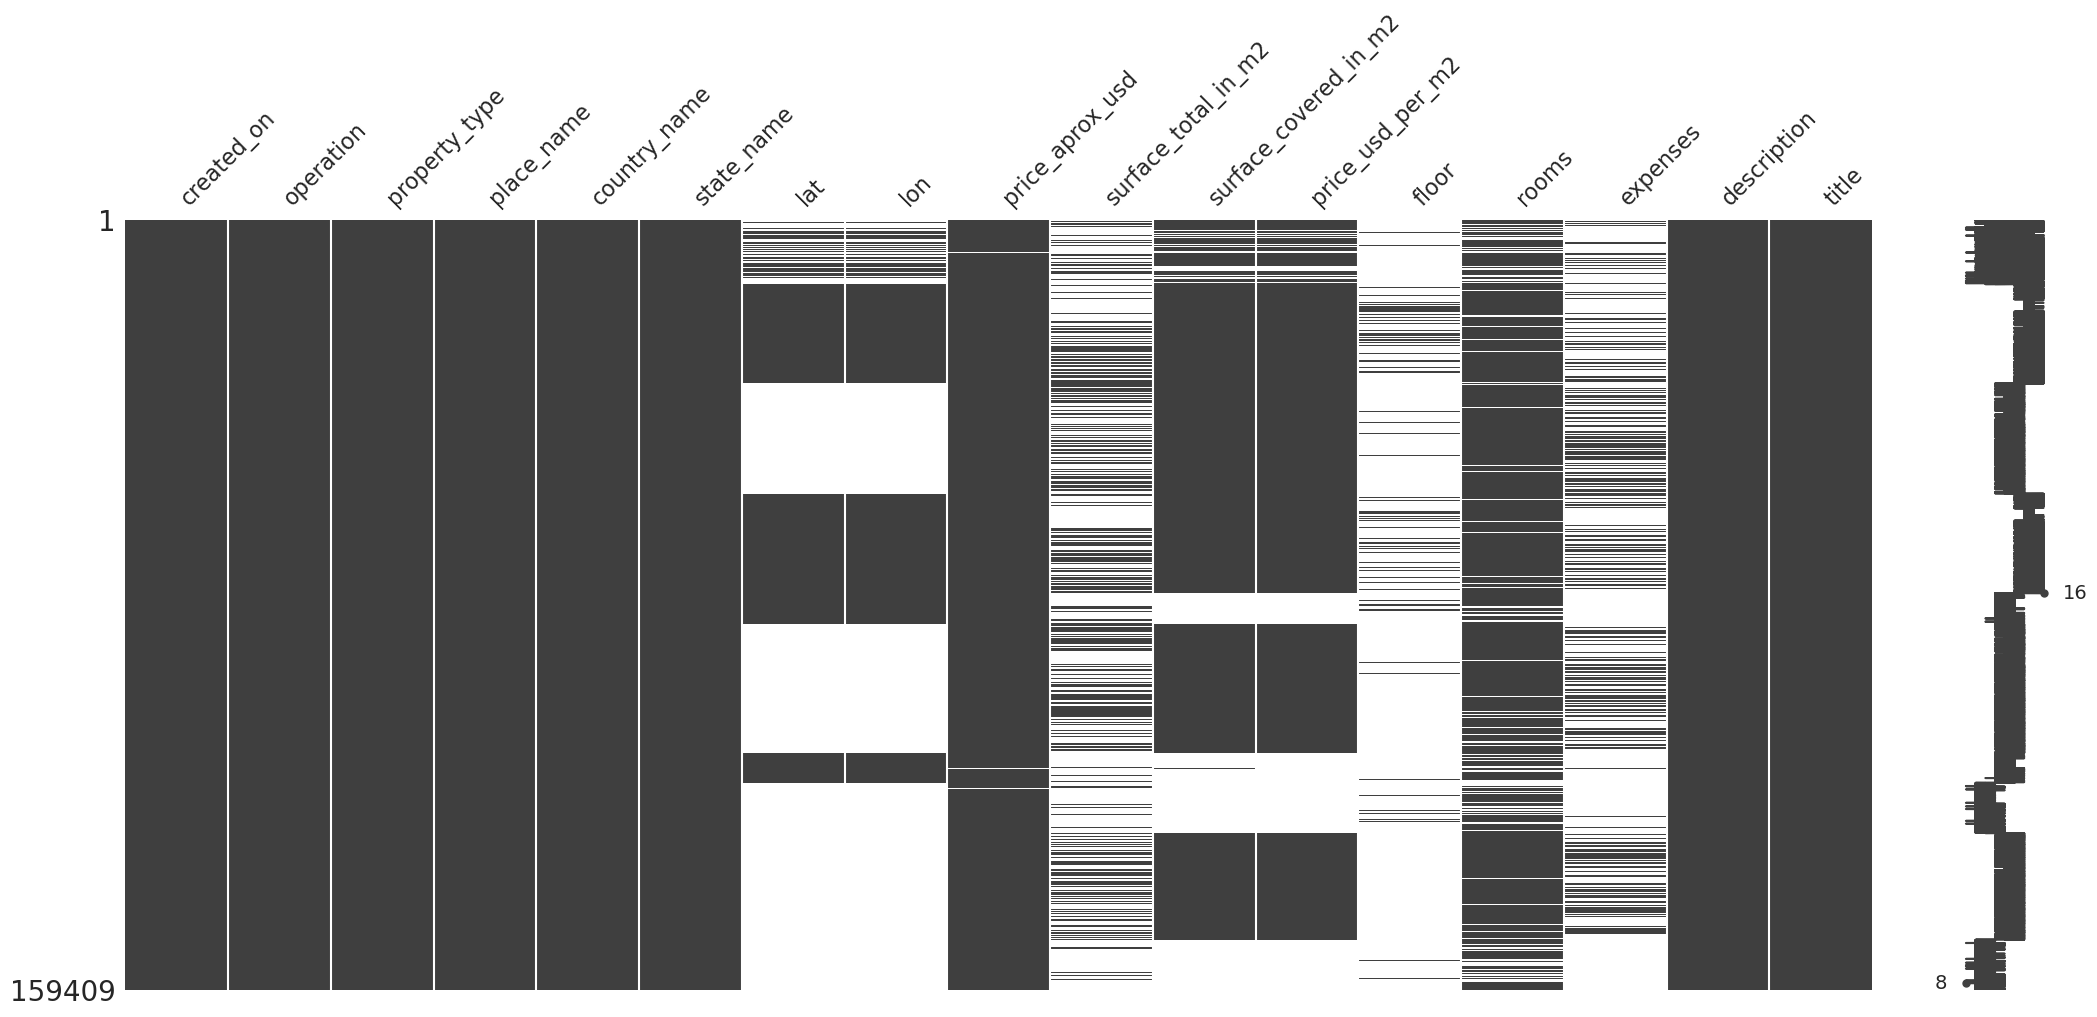

In [103]:
import missingno as msno
msno.matrix(main_data)

#### Floor

We have 91% of the data missing for floors. Hence, for the floor column, we will be grouping the data on the property type and calculate the median number of floors in the property for each type to proceed with the process of replacing nulls.

In [104]:
reference_table_floor = main_data\
    .dropna(subset=["floor"])\
    .groupby("property_type")\
    .agg({"floor": "median"})\
    .reset_index()

reference_table_floor

,property_type,floor
0,apartment,6.0
1,house,1.0
2,store,3.0


Now we join the above created reference table (which has the median value for each property type), to the main table, replacing the nulls in the floor column, with the median of each property type. 

In [105]:
main_data_imputed_floor = main_data\
    [main_data["floor"].isnull()]\
    .drop("floor", axis=1)\
    .merge(reference_table_floor, on="property_type", how="left")

After the join, we modify the order of the columns with the original column order we have.

In [106]:
main_data_imputed_floor = main_data_imputed_floor[['created_on', 'operation', 'property_type', 'place_name', \
                           'country_name', 'state_name', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', \
                           'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'description', \
                           'title']]

main_data = pd.concat([main_data[~main_data["floor"].isnull()], main_data_imputed_floor])

After we join the table, we observe we still have around 2000 rows missing (almost negligible compared to the whole data). It is because of the PH values in the property type has all nulls in the floor column. There are no values present for the "Penthouse" in the data (2211 in count). Hence, we have only the PH values as nulls. 

#### Price per m2

In this column, there were initially __35732__ nulls. To impute this, we built a reference table with median values of price_per_m2 grouped by the State, Property type and Operation.

In [107]:
reference_ppm2 = main_data\
  .dropna(subset=["price_usd_per_m2"])\
  .groupby(["state_name", "property_type", "operation"])\
  .agg({"price_usd_per_m2":"median"})\
  .reset_index()

Further, we join this table with the main_data on the state, property type and operation to impute the Null values and then concatenate with the main data

In [108]:
main_data_imputed_ppm2 = main_data[main_data["price_usd_per_m2"].isnull()]\
    .drop("price_usd_per_m2", axis=1)\
    .merge(reference_ppm2, how="left", on=['state_name', 'property_type', 'operation'])

main_data_imputed_ppm2 = main_data_imputed_ppm2[
    ['created_on', 'operation', 'property_type', 'place_name', 'country_name', 'state_name', 'lat', 'lon', \
     'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', \
     'expenses','description', 'title']]

main_data = pd.concat([main_data[~main_data["price_usd_per_m2"].isnull()], main_data_imputed_ppm2])

#### Expenses

For the Expenses column, we will be grouping the data on the property type and operation type, calculating the mean of the expenses for each type.

In [109]:
expense_table = main_data\
    .dropna(subset=["expenses"])\
    .groupby(["property_type","operation"])\
    .agg({"expenses": "mean"})\
    .reset_index()
expense_table

,property_type,operation,expenses
0,apartment,rent,828.974618
1,apartment,sell,2443.884212
2,house,rent,699.096317
3,house,sell,6858.732760
4,store,rent,2536.385246
5,store,sell,60108.257812


Now we have our reference table for the expenses, for each combination of property type and operation. We will now join this table with the main table, to replace the null values in expenses with the mean values for type of property and operations

In [110]:
main_data_imputed_expenses = main_data\
    [main_data["expenses"].isnull()]\
    .drop("expenses", axis=1)\
    .merge(expense_table, on=["property_type","operation"], how="left")

After the join, we modify the order of the columns with the original column order we have.

In [111]:
main_data_imputed_expenses = main_data_imputed_expenses[['created_on', 'operation', 'property_type', 'place_name', \
                           'country_name', 'state_name', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', \
                           'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'description', \
                           'title']]

main_data = pd.concat([main_data[~main_data["expenses"].isnull()], main_data_imputed_expenses])

After we join the table, we observe we again have around 2000 rows missing (almost negligible compared to the whole data). It is because of the PH values in the property type has all nulls in the expenses column. There are no values present for the "Penthouse" in the data (2211 in count). Hence, we have only the PH values as nulls. 

#### Longitude/Latitude

Step 1: After initial examination, we discovered that over __50%__ of lat/lon were missing in our main_data. To impute those missing values, we first filtered out rows with null lat/lon and saved them in coor_na_free. For those rows, we computed the average lat/lon by each city where the properties are located and saved the result in lon_avg and lat_avg. The same procedure was repeated, but this time by each state. Finally, we created the table city which contains the lon/lat of each city from the cities_data table.

In [112]:
coor_na_free = main_data.dropna(subset = ['lon','lat'])

lon_avg = coor_na_free.groupby(['state_name','place_name']).agg({'lon':np.mean}).reset_index()
lat_avg = coor_na_free.groupby(['state_name','place_name']).agg({'lat':np.mean}).reset_index()

lon_avg_state = coor_na_free.groupby(['state_name']).agg({'lon':np.mean}).reset_index()
lat_avg_state = coor_na_free.groupby(['state_name']).agg({'lat':np.mean}).reset_index()

city = cities_data[['STATE', 'CITY', 'LAT', 'LONG']]

Step 2: We used the average lat/lon of all properties in the city whose lat/lon are not missing to impute the missing lat/lon for other properties in the same city with missing values in lat/lon. This was done by first subsetting the rows where lat/lon are missing, then dropping the lat/lon from these rows. Next, we merged (by left join) this subset with the lat_avg/lon_avg tables from step 1 which contain the average lat/lon of the properties in each city into a new table. Finally, after reordering, we concatenated this new table (with missing lat/lon filled in) with the part of the main_data where lat/lon are not missing. This method was also used in step 3 and step 4.

In [113]:
main_data_imputed_coordinate = main_data[main_data['lat'].isnull()].drop(['lat','lon'], axis = 1)
main_data_imputed_coordinate = main_data[main_data['lat'].isnull()].drop(['lat','lon'], axis = 1)

main_data_imputed_coordinate = main_data_imputed_coordinate.merge(lat_avg, 
                                                                  how = 'left', 
                                                                  on = ['state_name', 'place_name'])

main_data_imputed_coordinate = main_data_imputed_coordinate.merge(lon_avg, 
                                                                  how = 'left', 
                                                                  on = ['state_name', 'place_name'])

In [114]:
main_data_imputed_coordinate = main_data_imputed_coordinate[
    ['created_on', 'operation', 'property_type', 'place_name', 
     'country_name', 'state_name', 'lat', 'lon','price_aprox_usd', 
     'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 
     'floor', 'rooms', 'expenses', 'description', 'title']]

main_data = pd.concat([main_data[~main_data['lat'].isnull()], main_data_imputed_coordinate])

Step 3: There are, however, some cities in which every property has missing lat/lon values. Subsequently, we used the lat/lon of that specific city from cities_data to impute the missing values for those properties.

In [115]:
main_data_imputed_coordinate = main_data[main_data['lat'].isnull()].drop(['lat','lon'], axis = 1)
main_data_imputed_coordinate = main_data_imputed_coordinate.merge(city, 
                                                                  how = 'left', 
                                                                  left_on = ['state_name','place_name'],
                                                                  right_on = ['STATE','CITY'])

main_data_imputed_coordinate = main_data_imputed_coordinate.drop(['STATE','CITY'], axis = 1)
main_data_imputed_coordinate = main_data_imputed_coordinate.rename(columns = {'LAT':'lat', 'LONG':'lon'})

main_data_imputed_coordinate = main_data_imputed_coordinate[
    ['created_on', 'operation', 'property_type', 'place_name', 
     'country_name', 'state_name', 'lat', 'lon','price_aprox_usd', 
     'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 
     'floor', 'rooms', 'expenses', 'description', 'title']]

main_data = pd.concat([main_data[~main_data['lat'].isnull()], main_data_imputed_coordinate])

Step 4: After all this, we discovered that there are still __1,111__ cities with missing lat/lon values. Upon further research, we discovered these cities have no match in the cities_data, because they are not really cities, but villages, communities, neighborhoods, suburbs, independent villa/residential areas, which are subdivisions of a city within the city(e.g. Downtown Crossing in Boston). Hence, we use the average lat/lon of the state in which those properties are located to impute the missing lat/lon values. With this step, we completed the imputation for missing lat/lon values.

In [116]:
main_data_imputed_coordinate = main_data[main_data['lat'].isnull()].drop(['lat','lon'], axis = 1)
main_data_imputed_coordinate = main_data_imputed_coordinate.merge(lat_avg_state, 
                                                                  how = 'left', 
                                                                  on = ['state_name'])
main_data_imputed_coordinate = main_data_imputed_coordinate.merge(lon_avg_state, 
                                                                  how = 'left', 
                                                                  on = ['state_name'])
main_data_imputed_coordinate = main_data_imputed_coordinate[
    ['created_on', 'operation', 'property_type', 'place_name', 
     'country_name', 'state_name', 'lat', 'lon','price_aprox_usd', 
     'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 
     'floor', 'rooms', 'expenses', 'description', 'title']]
main_data = pd.concat([main_data[~main_data['lat'].isnull()], main_data_imputed_coordinate])

#### Surface Total Area M2

Here it was observed that the column “Surface Total Area” had __59.01%__ (94081 out of 159,409 rows) null values. For meaningful analysis, the values were imputed by creating a reference data-frame, consisting of total surface area & number of rooms.

In [117]:
reference_variable_surface_area = main_data[['surface_total_in_m2','rooms']]\
  .dropna(subset=["surface_total_in_m2"])\
  .groupby("rooms")\
  .agg("median")\
  .reset_index()

Further, we are imputing the null values of “Surface Total Area” by merging the reference data-frame with main data and concatenating it back

In [118]:
main_data_imputed_surface_total_in_m2 = main_data[(main_data["surface_total_in_m2"].isnull()) & (~main_data["rooms"].isnull())]\
  .drop(["surface_total_in_m2"], axis=1)\
  .merge(reference_variable_surface_area, how = 'left', on = 'rooms')

main_data_imputed_surface_total_in_m2 = main_data_imputed_surface_total_in_m2[['created_on', 'operation', 'property_type', 'place_name', 'country_name', 'state_name', 'lat', 'lon', 'price_aprox_usd', \
                                          'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses','description','title']]

main_data = pd.concat([main_data[~((main_data["surface_total_in_m2"].isnull()) & (~main_data["rooms"].isnull()))], main_data_imputed_surface_total_in_m2])

#### Surface Covered Area M2

It was observed that this column had __22%__ (35641 out 159,409 rows) null values, for which we again used the concept of reference table to compare the median of number of rooms for imputing the null values.

In [119]:
reference_variable_surface_covered_area = main_data[['surface_covered_in_m2','rooms']]\
  .dropna(subset=["surface_covered_in_m2"])\
  .groupby("rooms")\
  .agg("median")\
  .reset_index()

In [120]:
main_data_imputed_surface_curved_in_m2 = main_data[(main_data["surface_covered_in_m2"].isnull()) & (~main_data["rooms"].isnull())]\
  .drop(["surface_covered_in_m2"], axis=1)\
  .merge(reference_variable_surface_covered_area, how = 'left', on = 'rooms')

main_data_imputed_surface_curved_in_m2 = main_data_imputed_surface_curved_in_m2[['created_on', 'operation', 'property_type', 'place_name', 'country_name', 'state_name', 'lat', 'lon', 'price_aprox_usd', \
                                          'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses','description','title']]

main_data = pd.concat([main_data[~((main_data["surface_covered_in_m2"].isnull()) & (~main_data["rooms"].isnull()))], main_data_imputed_surface_curved_in_m2])

#### Let's see how our data looks after Imputation!

<AxesSubplot:>

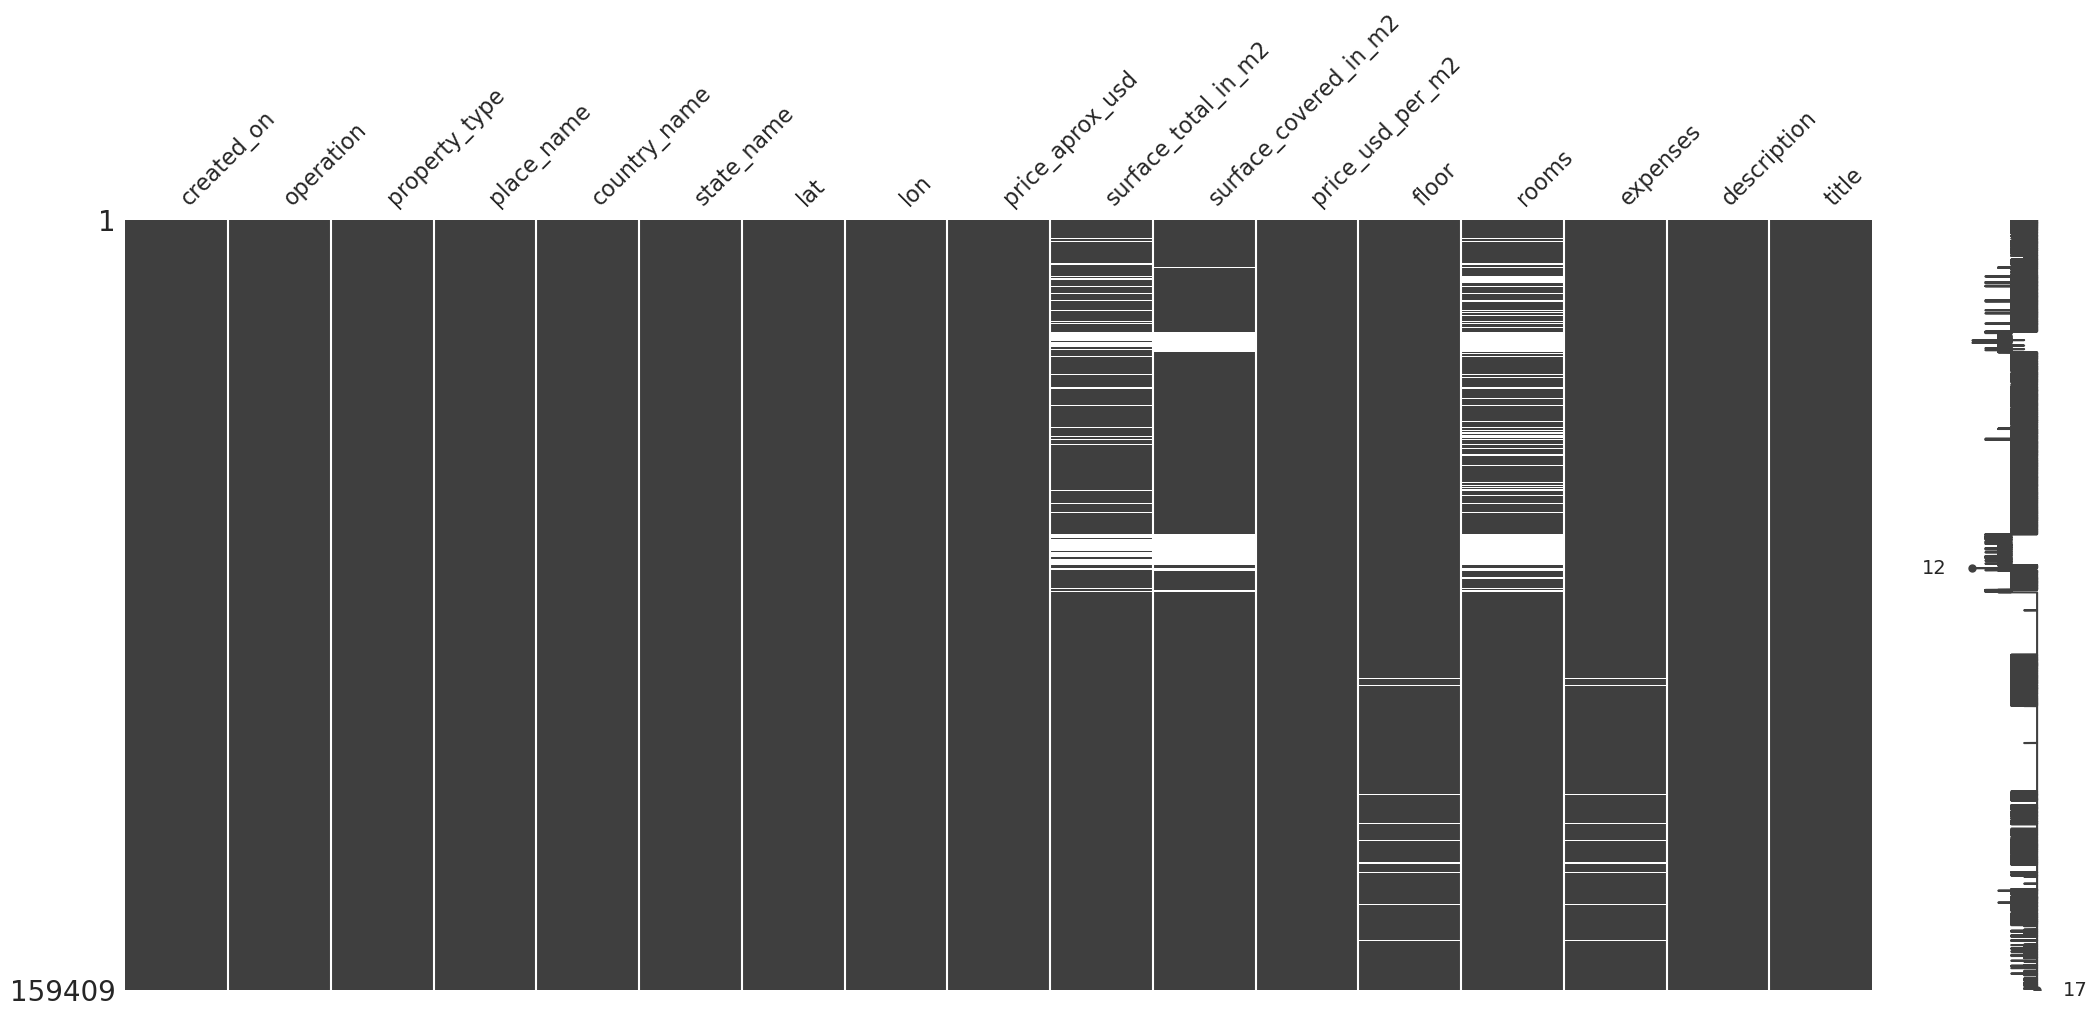

In [121]:
msno.matrix(main_data)

<hr>
<a id="DataExploration"></a>

## IV. Data Exploration
### Basic Statistics:

In [122]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159409 entries, 121 to 23718
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   created_on             159409 non-null  object 
 1   operation              159409 non-null  object 
 2   property_type          159409 non-null  object 
 3   place_name             159409 non-null  object 
 4   country_name           159409 non-null  object 
 5   state_name             159409 non-null  object 
 6   lat                    159409 non-null  float64
 7   lon                    159409 non-null  float64
 8   price_aprox_usd        159177 non-null  float64
 9   surface_total_in_m2    145984 non-null  float64
 10  surface_covered_in_m2  147486 non-null  float64
 11  price_usd_per_m2       159358 non-null  float64
 12  floor                  157198 non-null  float64
 13  rooms                  136779 non-null  float64
 14  expenses               157198 non-n

In [123]:
main_data.describe()

,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses
count,159409.000000,159409.000000,1.591770e+05,145984.000000,1.474860e+05,1.593580e+05,157198.000000,136779.000000,1.571980e+05
mean,-23.027936,-46.573565,2.587761e+05,239.036079,8.511556e+03,1.957519e+03,4.440056,2.614217,4.635262e+03
std,3.469005,2.036726,5.327564e+05,511.263955,3.156404e+06,2.119240e+04,12.254936,1.027301,5.052394e+04
min,-34.337131,-70.193504,5.143000e+01,0.000000,0.000000e+00,3.100103e-07,1.000000,1.000000,1.000000e+00
25%,-23.644546,-47.027912,8.454938e+04,95.000000,6.500000e+01,1.045709e+03,1.000000,2.000000,8.289746e+02
50%,-23.560383,-46.670198,1.473827e+05,154.000000,1.000000e+02,1.471695e+03,6.000000,3.000000,2.443884e+03
75%,-23.159223,-46.525234,2.768038e+05,210.000000,1.800000e+02,1.983337e+03,6.000000,3.000000,6.858733e+03
max,0.034745,-34.808968,3.551464e+07,48991.000000,1.212121e+09,6.896672e+06,4404.000000,34.000000,9.000000e+06


In [124]:
main_data.corr()

,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses
lat,1.000000,0.692959,-0.006059,0.025603,-0.000353,-0.000735,-0.005212,0.039185,0.000515
lon,0.692959,1.000000,0.014242,-0.000119,0.000097,0.002240,0.008739,-0.020836,-0.001865
price_aprox_usd,-0.006059,0.014242,1.000000,0.243811,-0.001157,0.091425,-0.002897,0.340205,0.048060
surface_total_in_m2,0.025603,-0.000119,0.243811,1.000000,-0.000736,-0.000826,-0.028857,0.333286,0.023550
surface_covered_in_m2,-0.000353,0.000097,-0.001157,-0.000736,1.000000,-0.000241,0.000311,-0.001587,-0.000191
price_usd_per_m2,-0.000735,0.002240,0.091425,-0.000826,-0.000241,1.000000,0.002826,0.005730,0.004501
floor,-0.005212,0.008739,-0.002897,-0.028857,0.000311,0.002826,1.000000,-0.035694,-0.009745
rooms,0.039185,-0.020836,0.340205,0.333286,-0.001587,0.005730,-0.035694,1.000000,0.016360
expenses,0.000515,-0.001865,0.048060,0.023550,-0.000191,0.004501,-0.009745,0.016360,1.000000


### Questions with Answers

1. __Geographical__ - Which state has highest & lowest, average priced property?

Here, we will calculate the average price of properties across all state names, and present in ascending order

In [125]:
hdi = cities_data[['STATE', 'CITY', 'IDHM', 'RURAL_URBAN']]
reference_price_hdi = main_data[['state_name','place_name','price_aprox_usd', 'operation']].merge(hdi, how = 'left',
                                 left_on = ['state_name','place_name'], right_on = ['STATE', 'CITY'])
reference_price_hdi = reference_price_hdi[['state_name','place_name', 'price_aprox_usd', 'IDHM','RURAL_URBAN','operation']].dropna()

In [126]:

check = reference_price_hdi\
    .groupby("state_name").mean().reset_index()\
    [["state_name", "price_aprox_usd","IDHM"]]\
    .sort_values(by="price_aprox_usd", ascending = True)

check.head()

,state_name,price_aprox_usd,IDHM
16,Piauí,161.374286,0.670429
10,Mato Grosso do Sul,19487.029412,0.735294
8,Maranhão,52863.982000,0.735200
20,Rondônia,53446.485000,0.691000
1,Amapá,87595.295000,0.733000


Now let's plot a bar chart to obtain a better visualisation of the above result. Note: These prices include the prices of operations (rent/sale) in common. 

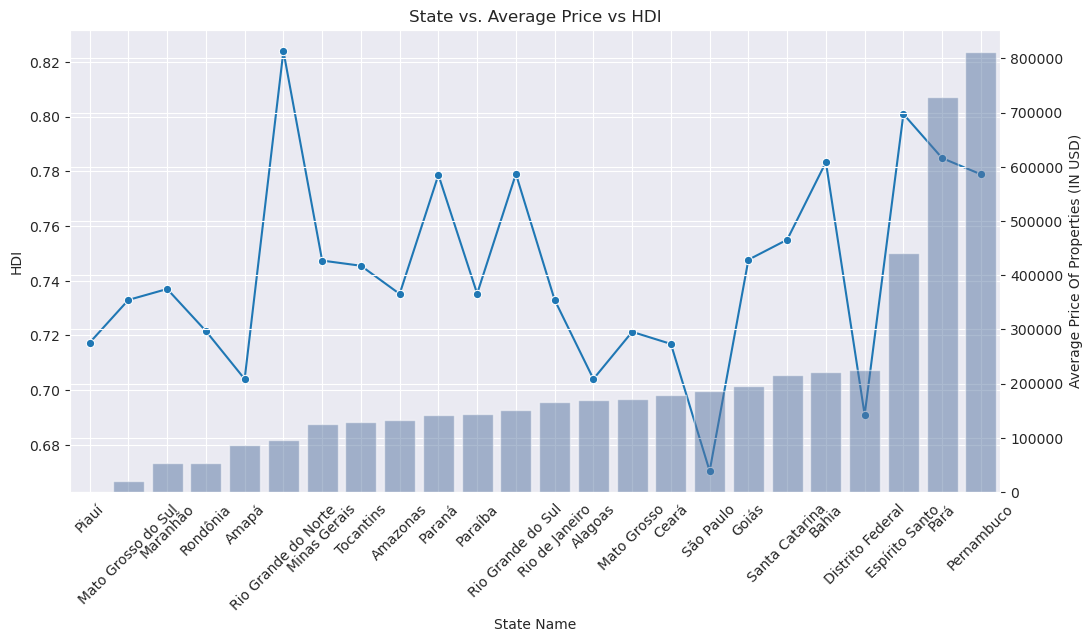

In [127]:
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))
plt.xticks(rotation=45)

g = sns.lineplot(data = check['IDHM'], marker='o', ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data = check, x='state_name', y='price_aprox_usd', alpha=0.5, ax=ax2, palette=sns.color_palette(['#4C74AE']))

g.set(xlabel="State Name", ylabel="HDI")
plt.ylabel("Average Price Of Properties (IN USD)")
plt.title("State vs. Average Price vs HDI");
plt.show()

It is observed that cities with higher average price tend to have HDI above 0.76. The cities with the highest range of price in properties are Para, Pernambuco, and Espirito Santo.

It is observed that the city "Rio Grande do Norte" has the highest HDI - above 0.82, and if we look at the average price of the properties here, it can be counted among the cities with the cheapest properties. 

It is observed that the city Espirito Santo has the second highest HDI among all, but it has the property ranges in higher ranges. 

It is observed that the city with lowest HDI - Sao Paulo and Distrito Federal has property prices high middle range (~$200,000). The cities with a good cheaper range of property and almost to 0.78 HDI could be Bahia, Amazonas and Paraiba. 

2. __Number/Area of rooms__ - How price depends on number of rooms? 

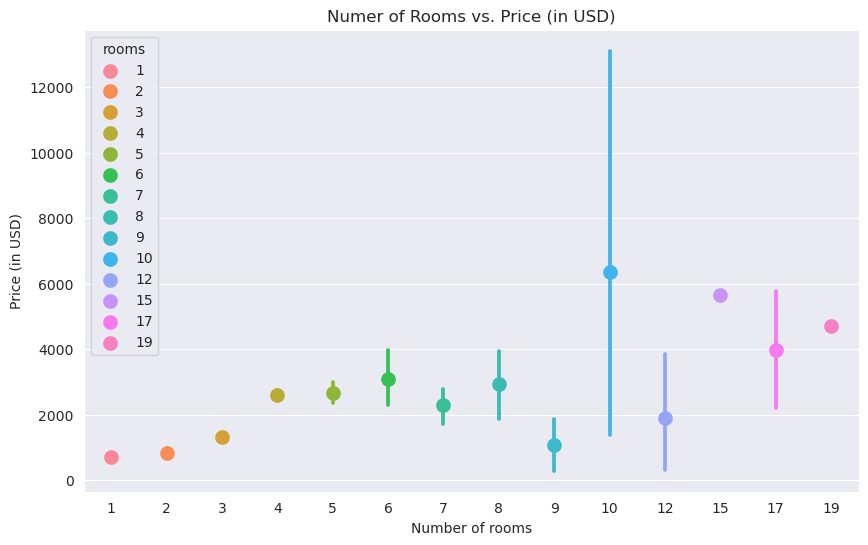

In [128]:
sns.set_style("darkgrid")
rooms_vs_price_approx_usd_rent = main_data[main_data['operation'] == 'rent'].dropna(subset=["rooms"])
rooms_vs_price_approx_usd_rent["rooms"] = rooms_vs_price_approx_usd_rent["rooms"].astype("int")
plt.figure(figsize=(10, 6))
sns.pointplot(x='rooms',y='price_aprox_usd',data=rooms_vs_price_approx_usd_rent, hue='rooms', scale=1.2, estimator="mean")
plt.xlabel('Number of rooms')
plt.ylabel('Price (in USD)')
plt.title('Numer of Rooms vs. Price (in USD)');

From the central tendencies of “Price in USD” and “No of Rooms” for rental operations, we can observe that as the number of rooms increase, the price of the property increases. But, a legitimate upward trend has been seen with rooms <= 5.

3. __Property Type and Location__ - How does the property type and urbanization of the city in which the property is located affect price?

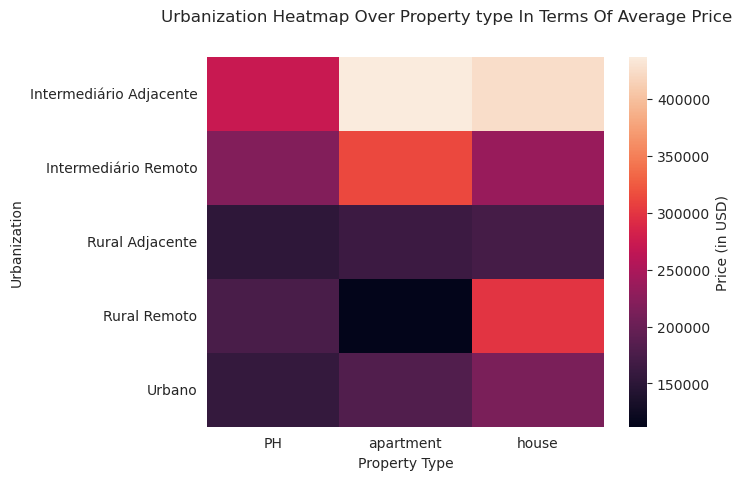

In [129]:
sns.set_style("darkgrid")
hp = main_data\
    .merge(cities_data[["CITY", "RURAL_URBAN"]], left_on="place_name", right_on="CITY", how="left")\
    .query("property_type != 'store'")\
    .groupby(["RURAL_URBAN", "property_type"]).agg({"price_aprox_usd":"mean"})\
    .pivot_table(index="RURAL_URBAN", columns="property_type", values="price_aprox_usd")\
    .query("RURAL_URBAN != '0'")\

chart = sns.heatmap(hp, cbar_kws={'label': 'Price (in USD)'})
chart.set(xlabel='Property Type', ylabel='Urbanization')
plt.suptitle("Urbanization Heatmap Over Property type In Terms Of Average Price");

For properties that are "Houses", we observe that the average price in Urbano, Rural Remoto, Intermediario Remoto, and Intermediario Adjacent is high, while Rural Adjacent has relatively low average prices.

For properties that are "Apartment", we observe that the average price in Urbano, Rural Remoto, Rural Adjacent, Intermediario Remoto, and Intermediario Adjacent is high, while Rural Remoto is relatively low.

For properties that are "Penthouse", we observe that the average price in Urbano, Rural Remoto, and Rural Adjacent are relatively low in Rural Remoto, while Intermediario Remoto and Intermediario Adjacent are high.

Overall, the average price for properties "Intermediario Adjacent" cities regardless of the property type are pretty high.

4. __Urbanization__ - Which area among urban or rural has max sized properties?

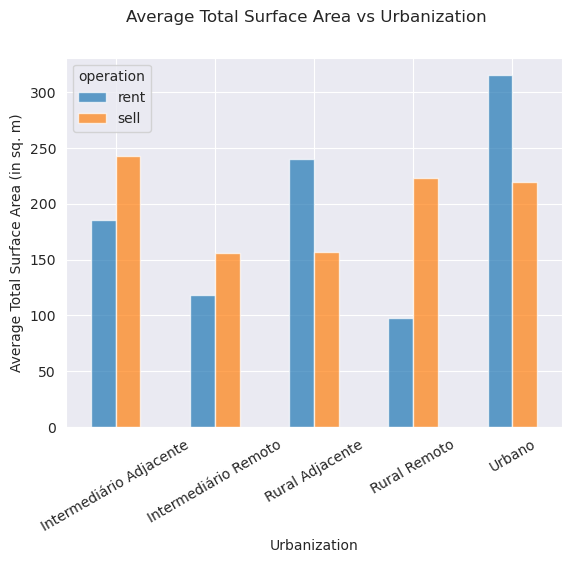

In [130]:
sns.set_style("darkgrid")
ax = main_data\
    .merge(cities_data[["CITY", "RURAL_URBAN"]], left_on="place_name", right_on="CITY", how="left")\
    .groupby(["RURAL_URBAN", "operation"]).agg({"surface_total_in_m2":"mean"})\
    .pivot_table(index="RURAL_URBAN", columns="operation", values="surface_total_in_m2")\
    .query("RURAL_URBAN != '0'")\
    .reset_index()\
    .plot(kind="bar", x="RURAL_URBAN", y=["rent", "sell"], rot=30, alpha=0.7)
plt.suptitle("Average Total Surface Area vs Urbanization")
ax.set_xlabel("Urbanization")
ax.set_ylabel("Average Total Surface Area (in sq. m)");

5. __Economic Status__ - How does a city’s economic status affect price?

We want to find out the relationship between property price and the corresponding HDI of the city where the property is located while taking rural vs urban into account.

First, we merged the cities_data table with our main_data table to get the information we needed for each property: the state name, city name, city HDI, and the rural vs urban information of the city where the property is located, as well as the property's price (in USD) and operation type.

In [131]:
hdi = cities_data[['STATE', 'CITY', 'IDHM', 'RURAL_URBAN']]
price_vs_hdi = main_data[['state_name','place_name','price_aprox_usd', 'operation']].merge(hdi, how = 'left',
                                 left_on = ['state_name','place_name'], right_on = ['STATE', 'CITY'])
price_vs_hdi = price_vs_hdi[['state_name','place_name', 'price_aprox_usd', 'IDHM','RURAL_URBAN','operation']].dropna()

Further, we explored the relationship between property price and the HDI of the city where the property is located.

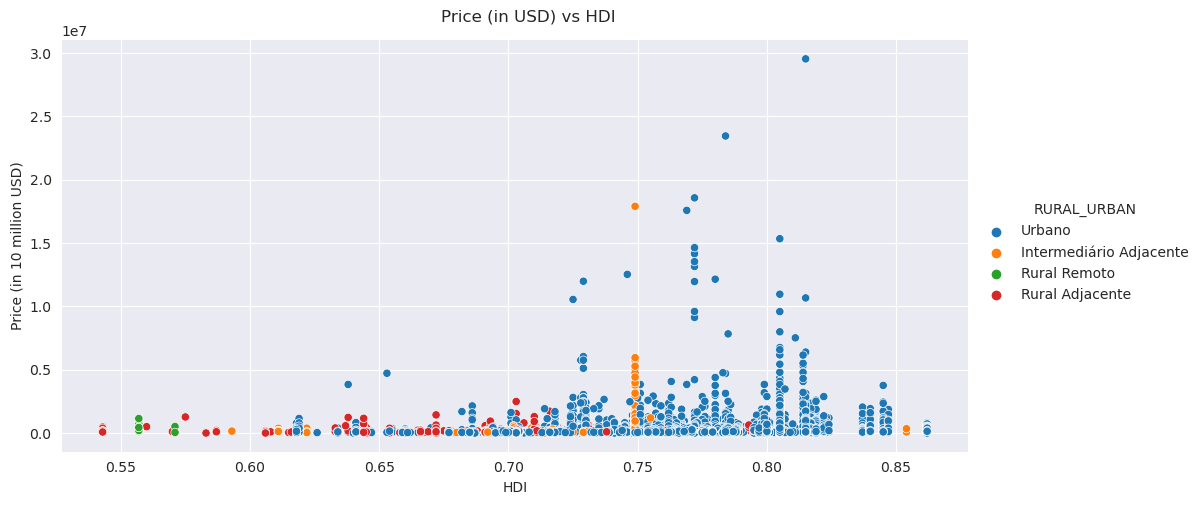

In [132]:
sns.set_style("darkgrid")
g = sns.relplot(data = price_vs_hdi, x = 'IDHM', y = 'price_aprox_usd', hue = 'RURAL_URBAN', kind = 'scatter', aspect = 2)
g.set(xlabel="HDI", ylabel="Price (in 10 million USD)")
g.fig.suptitle('Price (in USD) vs HDI', x = 0.45, y = 1)
plt.show()

Major Discoveries:

1. Apparently, the cities with high HDI have more properties listed, and the prices of those properties also tend to be higher than those in cities with lower HDI.

2. We can also observe that cities which are in rural areas (Rural Adjacente/Rural Remoto) have fewer properties listed.

3. Worth noting that some cities of Intermediario Adjacente type have relatively high price listings, as the Brazilian government has a plan to modernize and develop those areas. Hence, those areas have great potential and thus higher housing price.

<hr>
<a id="Conclusions"></a>

## V. Conclusions

- In conclusion, if one requires the cheapest properties, we would need to look at Rural Adjacent and Urban regions of Brazil. Although, the Rural Adjacent regions have relatively __low__ human development and thus won't be the optimal choice for a safe and healthy community.

- On the other hand, looking at Intermediate cities, we generally observe higher property prices combined with smaller property sizes. So, they may not be the best choice.

- If one wants to buy an apartment with a __low__ budget, then the apartments in the “Rural Remote” or “intermeidario Adjacent” cities are suitable as the prices are reasonable. If the budget is __high__, then the apartments in “Intermediary Remoto” or “Rural Remoto” cities are suitable. In general, properties in "Rural Adjacente" cities are suitable since the community is well developed and the mean area is large.

- If a person is looking for a property to rent with a budget of $5000, it is recommended that they should not seek properties having more than 5 rooms.

- In terms of HDI, the density of the properties are relatively high where the location with higher HDI. Instead, the lower the HDI, the fewer properties list in the area. The reason is that the Brazilian government plans to modernize and develop these areas. As a result, these areas have great potential and hence higher house prices.

- __Rio Grande do Norte, Amazonas and Parabia__ are particularly value-for-money cities as they have properties in lower price ranges ($100-200k) while providing better life quality. On the other hand, Sao Paulo and Distrito Federal cities provide lower life quality while having more expensive properties. So, we would not suggest them as a good choice.

- It would be wise to choose properties in cities with high HDI indexes for better quality of life. Therefore, buyers with large budget(> $3M) are recommended to search properties in Urbano areas having better quality life. Whereas, buyers should also consider Intermediario Adjacente areas, since they provide great value for investment, and buyers with a lower budget can also consider renting in the aforementioned areas.

<a id="References"></a>
***
## VI. References

“Brazilian Cities.” Kaggle, https://www.kaggle.com/datasets/crisparada/brazilian-cities?select=BRAZIL_CITIES_REV2022.CSV. 

“ISO 3166-2:BR.” Wikipedia, Wikimedia Foundation, 18 Sept. 2022, https://en.wikipedia.org/wiki/ISO_3166-2:BR.

Guedes, Gilvan, et al. “Revisiting the Hierarchy of Urban Areas in the Brazilian Amazon: A Multilevel Approach.” Population and Environment, U.S. National Library of Medicine, May 2009, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3488306/. 


“Matplotlib 3.6.2 Documentation#.” Matplotlib Documentation - Matplotlib 3.6.2 Documentation, https://matplotlib.org/stable/index.html. 


Nations, United. “Human Development Index.” Human Development Reports, 9 Nov. 2022, https://hdr.undp.org/data-center/human-development-index#/indicies/HDI. 


“Properati Data.” Properati., https://www.properati.com.ar/data. 


“Rural and Urban Typologies in Brazil a Comparison with the Proposed Global Methodology Claudio Stenner Coordinator of Geography of Brazilian Institute. - PPT Carregar.” SlidePlayer, https://slideplayer.com.br/slide/17498136/. 


“Seaborn.heatmap.” Seaborn.heatmap - Seaborn 0.12.1 Documentation, https://seaborn.pydata.org/generated/seaborn.heatmap.html. 


“Sign In.” RPubs, https://rpubs.com/agrilive/brazil-development-analysis. 

